# Zebrahub: single cell analysis QC 
**Jan 2023** <br>
Goals:<br>
* Load samplees from CellRanger
* Find optimal filters across samples
* Find which samples are high quality
* Export and h5ad object with basic processing (QC, clustering, UMAP, etc.) 

In [194]:
pwd

'/data/alejandro/danio-atlas/data'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import scanpy as sc
import glob

# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=150)

Global variables: File Directories 

In [29]:
COUNTS_DIR = '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/' # count matrices from CellRanger
ATLAS_DIR = '/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/'   # Save concatenated h5ad here 

# 1. Load CellRanger files and generate adata objects

We assume that all count matrices from CellRanger are located in the same directory, with a sub-folder for each sample (sequencing run)<br>
The directory has a specific structure that will depend on the project and how the data was organized <br>
Pay attention to the sub-folder structure since it will affect how the following code will perform. 

In [12]:
# Let's extract the folder structure for this project 
# For Zebrahub, we have all count matrices in the same directory
mtx10X = glob.glob(COUNTS_DIR + '*/')
mtx10X.sort()

# For this project, the metadata is included in a sub-folder name 
# NOTE: Although this is a very common practice it is NOT RECOMMENDED 
# The metadata should be imported from a .csv file that is carefully curated and matches the sample names. 
meta_ = glob.glob(COUNTS_DIR + '*/*/*/*')
meta_.sort() 

In [51]:
pwd

'/data/alejandro/danio-atlas/data'

In [15]:
# Let's look at the folder names for the first 5 samples
mtx10X[0:5]

['/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/Pilot1/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR100/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR101/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR102/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR103/']

We can see the sample metadata in the folder structure -- we will need to parse the metadata using regular expressions

In [16]:
meta_[0:5]

['/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/Pilot1/alignment_Danio.rerio_genome/10x/pilot',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR100/alignment_Danio.rerio_ZebraBow_genome/10x/TDR100_20snew_EKW_NA_none_10x',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR101/alignment_Danio.rerio_ZebraBow_genome/10x/TDR101_20snew_EKW_NA_none_10x',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR102/alignment_Danio.rerio_ZebraBow_genome/10x/TDR102_20snew_EKW_NA_none_10x',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR103/alignment_Danio.rerio_ZebraBow_genome/10x/TDR103_20snew_EKW_NA_none_10x']

## 1.1 Optional: Select only the samples to be loaded 

A large project like Zebrahub contains multiple samples that typically belong to different projects and biological questions. <br>
While processing all samples together might be of use when building an atlas, most of the times we are interested in a subset of samples. <br>
For example, we might be adding data to an existing project, in which case we don't need to re-process all samples <br>
Here we are going to subset the list of samples and only load those that we are interested in.<br>

In [54]:
import re 

# The samples for the Zebrahub dataset are named using the nomenclature: TDR + sample ID 
# The full metadata is available HERE <<<<- INSERT LINK
#
# As you can see, the numbers by themselves don't mean too much, so we need to look at the metadata spreadsheet before selecting the samples that we will analyze 

# Example 1: 
# Samples 18-47 include the early developmental stages of Zebrafish -- 
which_samples = [*range(18,47)] 

# Example 2: 
# Late development: TDR47-TDR54 are the Day 2 and Day 5 of Zebrafish development, while samples and TDR67 - TDR74 correspond to Day 3 and Day 10
which_samples = [*range(47,55)] + [* range(67, 75) ]


# Example 3: 
# INSERT ONE MORE EXAMPLE HERE 

# Let's save those samples we want to analyze in a new list 
keep_samples = []
keep_meta = []

for i in range(len(mtx10X)):
    for s in which_samples: 
        p = re.compile(str(s))
        if(p.search(mtx10X[i])):
            keep_samples.append(mtx10X[i]) 
            keep_meta.append(meta_[i])


In [55]:
keep_samples[0:5]

['/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR47/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR48/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR49/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR50/',
 '/mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR51/']

In [56]:
len(keep_samples)

16

## Load metadata CSV file -- mandatory 

In [67]:
META_PATH = '/mnt/ibm_lg/alejandro/danio-atlas/metadata/'
META_FILE = 'projectTDR.csv'
meta_df = pd.read_csv(META_PATH + META_FILE ) 

# replace whitespace in the column names 
meta_df.columns = meta_df.columns.str.strip()
meta_df.columns = meta_df.columns.str.replace(" ", "_")
meta_df.columns = meta_df.columns.str.lower()

In [68]:
meta_df.head() 

fish_id time_point developmental_stage strain             library_prep  \
0   TDR18    14 hpf           10 somites    EKW  10x Single Cell 3' v3.1   
1   TDR19     14 hpf          10 somites    EKW  10x Single Cell 3' v3.1   
2   TDR21    14 hpf           10 somites    EKW  10x Single Cell 3' v3.1   
3   TDR22     14 hpf          10 somites    EKW  10x Single Cell 3' v3.1   
4   TDR23    10 hpf            0 somites    EKW  10x Single Cell 3' v3.1   

  sequencing_platform  
0   NovaSeq S4 4 Lane  
1   NovaSeq S4 4 Lane  
2   NovaSeq S4 4 Lane  
3   NovaSeq S4 4 Lane  
4   NovaSeq S4 4 Lane

Define a function to load a single sample

We can use the foler path as a structure <br>
**NOTE** let's change this function to read from a .csv file <br>
the csv file must have the sample name, and ANY number of columns <br>
the user can select which ones to keep, ['col1', 'col2',....]

New function: 
* One master folder with one subfolder per sample 
* The name of the subfolder will be the name of the sample 
* The user provides a csv file with all the metadata

In [80]:
def loadH5Folder(main_path='',           # path to h5 file (long name with subfolders)
                 sample_name = "",       # must be provided by the user 
                 min_genes_pcell = 100,  # basic QC 
                 min_counts_pcell = 100, # basic QC 
                ):
      
        adataaux = sc.read_10x_h5(main_path +'filtered_feature_bc_matrix.h5')
       
        adataaux.var_names_make_unique() 
        # Do basic filtering -- not QC! This is only to reduce the size of the file 
        sc.pp.filter_cells(adataaux, min_genes=min_genes_pcell)
        sc.pp.filter_cells(adataaux, min_counts=min_counts_pcell)
        
        # Add the sample name 
        adataaux.obs['sample_ID'] = sample_name
        # make a unique cell_id by including the sample ID to avoid duplicates 
        adataaux.obs['cell_id'] = adataaux.obs['sample_ID'] + "_" + adataaux.obs.index
        
        # Set the unique cell_id as index for adata.obs
        adataaux.obs = adataaux.obs.set_index("cell_id")
      
        return adataaux

## 1.2 Read and concatenate 
Let's read each adata object using Scanpy and save them into a list of adata objects. <br>
We can then concatenate all the objects into a single adata.

HERE is where the .csv metadata should be. <br>
Once we have the large adata, we can merge the metadata DF by sample ID. 

In [170]:
%%capture

adata_list = list() 

for path, meta in zip(keep_samples, keep_meta):
    
    sample_id  = path.split('/')[-2]
    adata_aux = loadH5Folder(main_path = path, sample_name = sample_id) 
    
    adata_list.append(adata_aux)

reading /mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR47/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR48/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
reading /mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR49/filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:00)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
filtered out 2 cells that have less than 100 genes expressed
reading /mnt/ibm_lg/alejandro/danio-atlas/count_matrices/TDR50/filtered_feature_bc_matrix.h5
Variable names are not unique. To ma

Concatenate using adata.concatenate

In [187]:
import anndata as ad

# merge = "same" keeps columns in adata
adata = ad.concat(adata_list,merge="same")

Check that metadata is correct in the concatenated object

In [188]:
adata.var.head() 

gene_ids    feature_types  \
ptpn12           ENSDARG00000102141  Gene Expression   
phtf2            ENSDARG00000102123  Gene Expression   
phtf2-1          ENSDARG00000114503  Gene Expression   
CU856344.1       ENSDARG00000115971  Gene Expression   
si:zfos-932h1.3  ENSDARG00000098311  Gene Expression   

                                        genome  
ptpn12           Danio.rerio_genome_Zebrabow_6  
phtf2            Danio.rerio_genome_Zebrabow_6  
phtf2-1          Danio.rerio_genome_Zebrabow_6  
CU856344.1       Danio.rerio_genome_Zebrabow_6  
si:zfos-932h1.3  Danio.rerio_genome_Zebrabow_6

In [189]:
adata.obs.head() 

n_genes  n_counts sample_ID
cell_id                                              
TDR47_AAACCCAAGAGCGACT-1      737    1607.0     TDR47
TDR47_AAACCCAAGAGTGGCT-1     1169    2932.0     TDR47
TDR47_AAACCCAAGCGACTTT-1      665    1380.0     TDR47
TDR47_AAACCCAAGTGCACCC-1     4089   22686.0     TDR47
TDR47_AAACCCACAAGAAACT-1      884    1515.0     TDR47

The adata.obs data frame contains metadata for each cell. We parsed this information from the sub-folder structure. However, a best practice would be to import this information from a .csv file and use pandas to join the data frames. 
<br>
The **sample_ID** should be unique for each sequencing run, in this case a single Zebrafish embryo. 

In [190]:
def add_metadata(adata_obj = [], 
                 metadata_df = [],                     # a data frame with all the metadata -- it must have the sample ID colum  
                 sample_index = 'fish_id',              # for zebrafish -- other examples: donor_id, sample_number, sample, sample_name, etc. 
                 cols_to_add = ['time_point','developmenta_stage','strain', 'sequencing_platform']  # the list of columns that we want to add to the adata object, it should be a subset of metadata_df.columns
                ):


    cols_to_add = [sample_index] + cols_to_add
    adata_obj.obs.rename(columns = {'sample_ID':sample_index }, inplace = True)
    # let's reset the index and add it as a column 
    adata_obj.obs.reset_index(inplace = True)
    # merge with metadata 
    df = pd.merge( adata_obj.obs, metadata_df[cols_to_add], 
                                  #left_index = True, right_on = sample_index) 
                                  on = sample_index, how = 'left')

    df.index = df.index.astype(str)
    # update obs 
    adata_obj.obs = df
    # set the index again 
    adata_obj.obs.set_index('cell_id', inplace = True)
    
    # returns updated adata object 
    return adata_obj

In [179]:
# adata_obj = adata.copy() 

# sample_index = 'fish_id'
# cols_to_add = [sample_index] + ['time_point','developmental_stage']
# adata_obj.obs.rename(columns = {'sample_ID':sample_index }, inplace = True)
# # let's reset the index and add it as a column 
# adata_obj.obs.reset_index(inplace = True)
# # merge with metadata 
# df = pd.merge( adata_obj.obs, metadata_df[cols_to_add], 
#                               #left_index = True, right_on = sample_index) 
#                               on = sample_index, how = 'left')

In [191]:
adata_ann = add_metadata(adata_obj = adata.copy() , metadata_df = meta_df, sample_index = 'fish_id', 
                         cols_to_add = ['time_point', 'developmental_stage', 'strain'])

In [192]:
adata_ann.obs.head() 

n_genes  n_counts fish_id time_point  \
cell_id                                                          
TDR47_AAACCCAAGAGCGACT-1      737    1607.0   TDR47       2dpf   
TDR47_AAACCCAAGAGTGGCT-1     1169    2932.0   TDR47       2dpf   
TDR47_AAACCCAAGCGACTTT-1      665    1380.0   TDR47       2dpf   
TDR47_AAACCCAAGTGCACCC-1     4089   22686.0   TDR47       2dpf   
TDR47_AAACCCACAAGAAACT-1      884    1515.0   TDR47       2dpf   

                         developmental_stage strain  
cell_id                                              
TDR47_AAACCCAAGAGCGACT-1         larval-2dpf    EKW  
TDR47_AAACCCAAGAGTGGCT-1         larval-2dpf    EKW  
TDR47_AAACCCAAGCGACTTT-1         larval-2dpf    EKW  
TDR47_AAACCCAAGTGCACCC-1         larval-2dpf    EKW  
TDR47_AAACCCACAAGAAACT-1         larval-2dpf    EKW

## 1.3 Save the raw data 
Although we haven't performed the Quality control yet, we can save the concatenated object for future reference or if the QC needs to be fine tuned. <br>
By saving the object at this point we won't need to re-run the previous sections. <br>
The raw object can be loaded into CellXGene or in a different Python notebook !

In [193]:
adata_ann.write(ATLAS_DIR + 'ZF_notebookTestJan2023_raw_counts.h5ad')

... storing 'fish_id' as categorical
... storing 'time_point' as categorical
... storing 'developmental_stage' as categorical
... storing 'strain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


We can now check that the metadata corresponds to the sample information <br>
In this case, we can check the decelopmental stage (time point) but for other projects we might be interested in donor, organ, or biological condition. <br>

In [47]:
adata.obs.timepoint.value_counts() 

3dpf     74137
5dpf     69146
10dpf    60122
2dpf     41052
Name: timepoint, dtype: int64

## Start QC 

Optional: filter out fish samples

In [38]:
# adata = adata[adata.obs.timepoint.isin(['2dpf','5dpf','3dpf','10dpf'])].copy() 

# contains only 3 fish 
# adata = adata[  adata.obs.fish_id.isn( ['TDR42','TDR56','TDR62'])  ].copy() 

## QC Figure 1: Histogram of counts per cell 

* We should a main histogram with all counts -- and we show a couple of trhesholds that should be good for 10x data. 
* We can also tell the user how many cells will be lost after applying such thresholds
* Finally, we can make a grid of histograms showing each sample and thre thresholds so we can see problematic samples 

In [49]:
adata.obs.head() 

n_genes  n_counts sample_ID fish_number timepoint  \
cell_id                                                                       
TDR47_AAACCCAAGAGCGACT-1      737    1607.0     TDR47          47      2dpf   
TDR47_AAACCCAAGAGTGGCT-1     1169    2932.0     TDR47          47      2dpf   
TDR47_AAACCCAAGCGACTTT-1      665    1380.0     TDR47          47      2dpf   
TDR47_AAACCCAAGTGCACCC-1     4089   22686.0     TDR47          47      2dpf   
TDR47_AAACCCACAAGAAACT-1      884    1515.0     TDR47          47      2dpf   

                          log_ncounts  log_ngenes  
cell_id                                            
TDR47_AAACCCAAGAGCGACT-1     3.206016    2.867467  
TDR47_AAACCCAAGAGTGGCT-1     3.467164    3.067815  
TDR47_AAACCCAAGCGACTTT-1     3.139879    2.822822  
TDR47_AAACCCAAGTGCACCC-1     4.355758    3.611617  
TDR47_AAACCCACAAGAAACT-1     3.180413    2.946452

<AxesSubplot:xlabel='log_ncounts', ylabel='Count'>

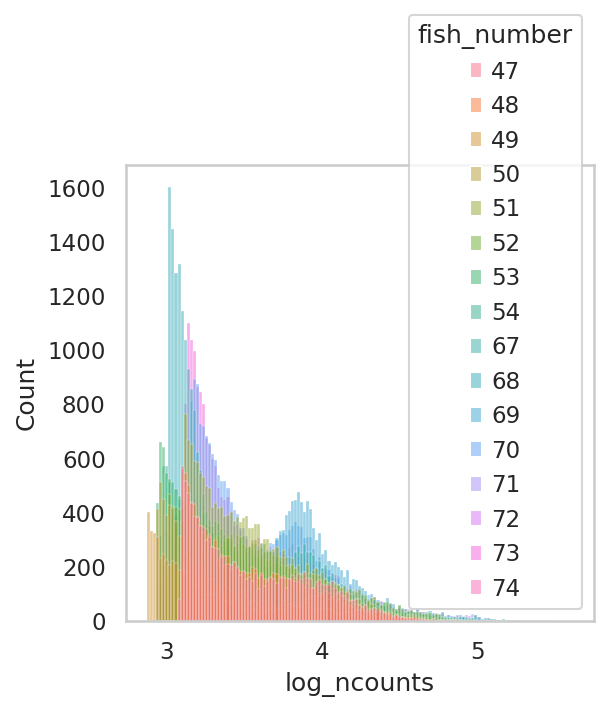

In [50]:
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})

adata.obs['log_ncounts'] = np.log10(adata.obs['n_counts'])
adata.obs['log_ngenes'] = np.log10(adata.obs['n_genes'])

sns.histplot(data = adata.obs, x ='log_ncounts', hue='fish_number')

Number of genes per cell

<AxesSubplot:xlabel='n_genes', ylabel='Count'>

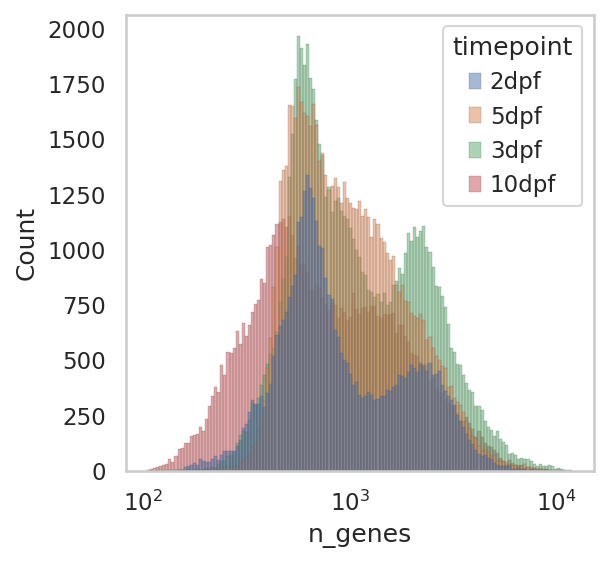

In [40]:
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})

sns.histplot(data = adata.obs, x ='n_genes', hue='timepoint',
               edgecolor=".3",
    linewidth=.1,log_scale = True)

After the grid plot, we could remove one samples 

adata = adata[adata.obs.sample =="problem_sample"].copy() 

## Figure 2: Violin plots for counts and genes 

Text(0.5, 1.0, 'Distribution counts per cell')

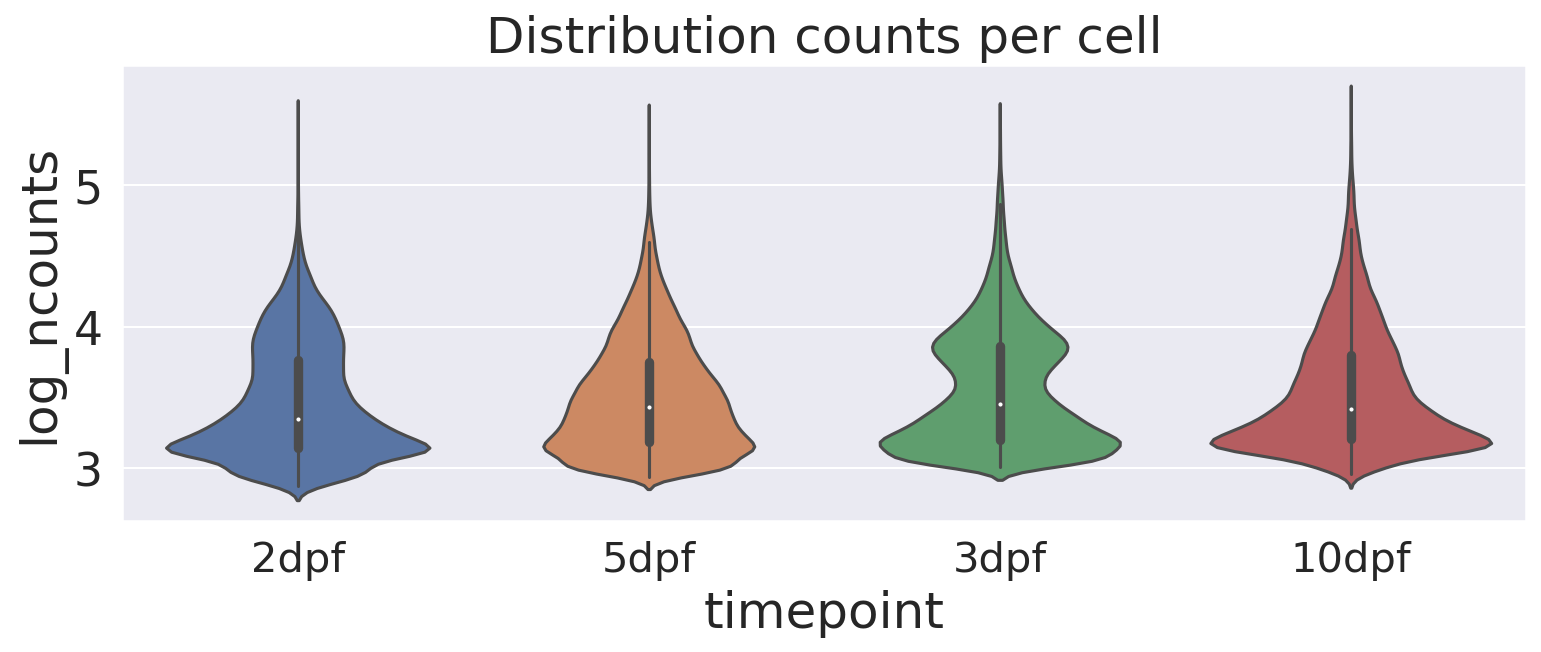

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 2)

violin_width = 12 
violin_height = 4
plt.figure(figsize=(violin_width,violin_height))

res = sns.violinplot(data =adata.obs, x= 'timepoint',y='log_ncounts' )
res =res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20) # assign to variable to supress text

plt.title('Distribution counts per cell')

Log counts by fish 

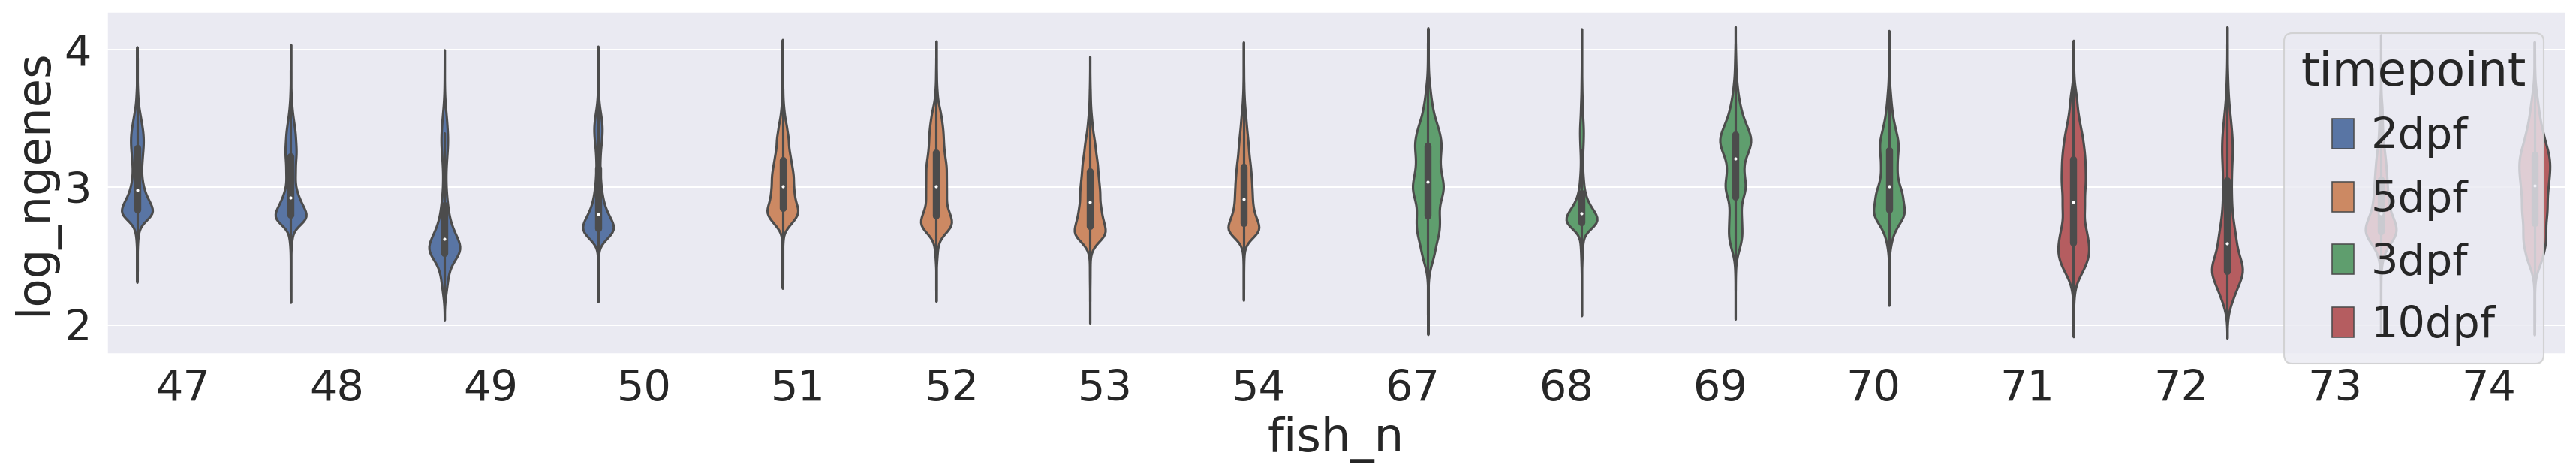

In [42]:
violin_width = 28 
violin_height = 4
sns.set(font_scale = 2.5)

plt.figure(figsize=(violin_width,violin_height))

res = sns.violinplot(data =adata.obs, x= 'fish_n',y='log_ngenes', hue='timepoint' )


Cells per fish 

In [43]:
adata.obs['fish'].value_counts() 

TDR70    21000
TDR73    19533
TDR68    18985
TDR69    18593
TDR51    18572
TDR53    18388
TDR52    16819
TDR74    16454
TDR67    15559
TDR54    15367
TDR71    12767
TDR47    12389
TDR48    11929
TDR72    11368
TDR50     9917
TDR49     6817
Name: fish, dtype: int64

## Figure 3: Genes with highest expression 

normalizing counts per cell
    finished (0:00:02)


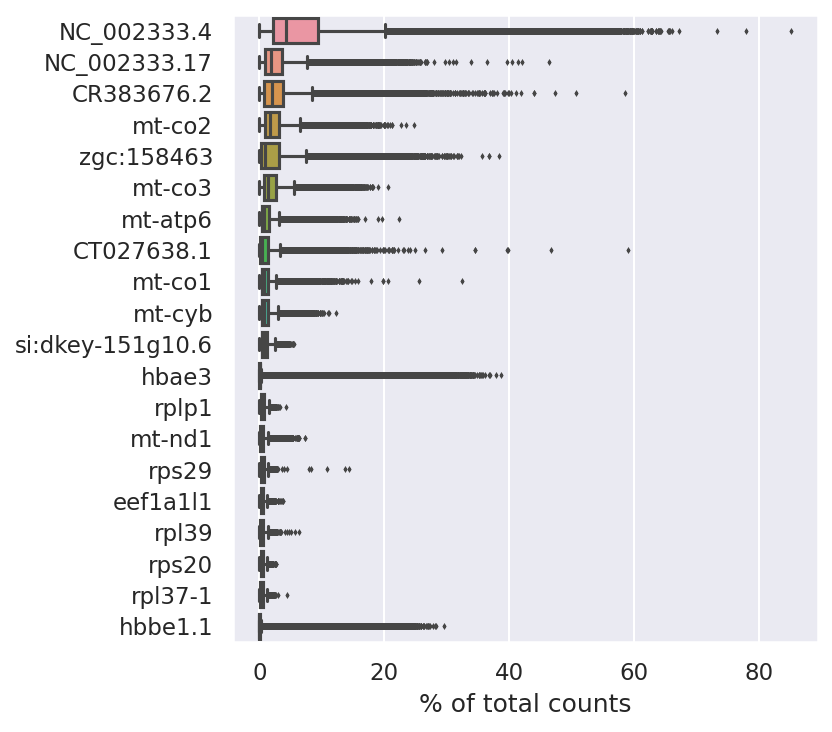

In [44]:
sns.set(font_scale = 1)

sc.pl.highest_expr_genes(adata, n_top=20, )

In [45]:
# References for parameter values
# A Schier / Alon Klein brain GESTALT 
# Cells with fewer than 500 expressed genes, greater than 9% mitochondrial content or very high numbers of UMIs and gene counts that were outliers of a normal distribution (likely doublets/multiplets) were removed from further analysis.

# https://www.nature.com/articles/s41467-020-16515-y
# cells were filtered out (excluded) based on the following criteria: <200 or >3500 unique genes expressed, or >5% of counts mapping to the mitochondrial genome.

### Filtering out NC_00233 and mitochondrial transcripts
We see unsual levels of NC mapped transcripts, particularly in 10 somite fish samples <br>
These are transcripts that we want to filter out (similar to mitochondrial genes) 

In [46]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['nc'] = adata.var_names.str.startswith('NC_')

### Scanpy QC metrics

In [47]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','nc'], percent_top=None, log1p=False, inplace=True)


... storing '10X_run' as categorical
... storing 'fish' as categorical
... storing 'fish_n' as categorical
... storing 'timepoint' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


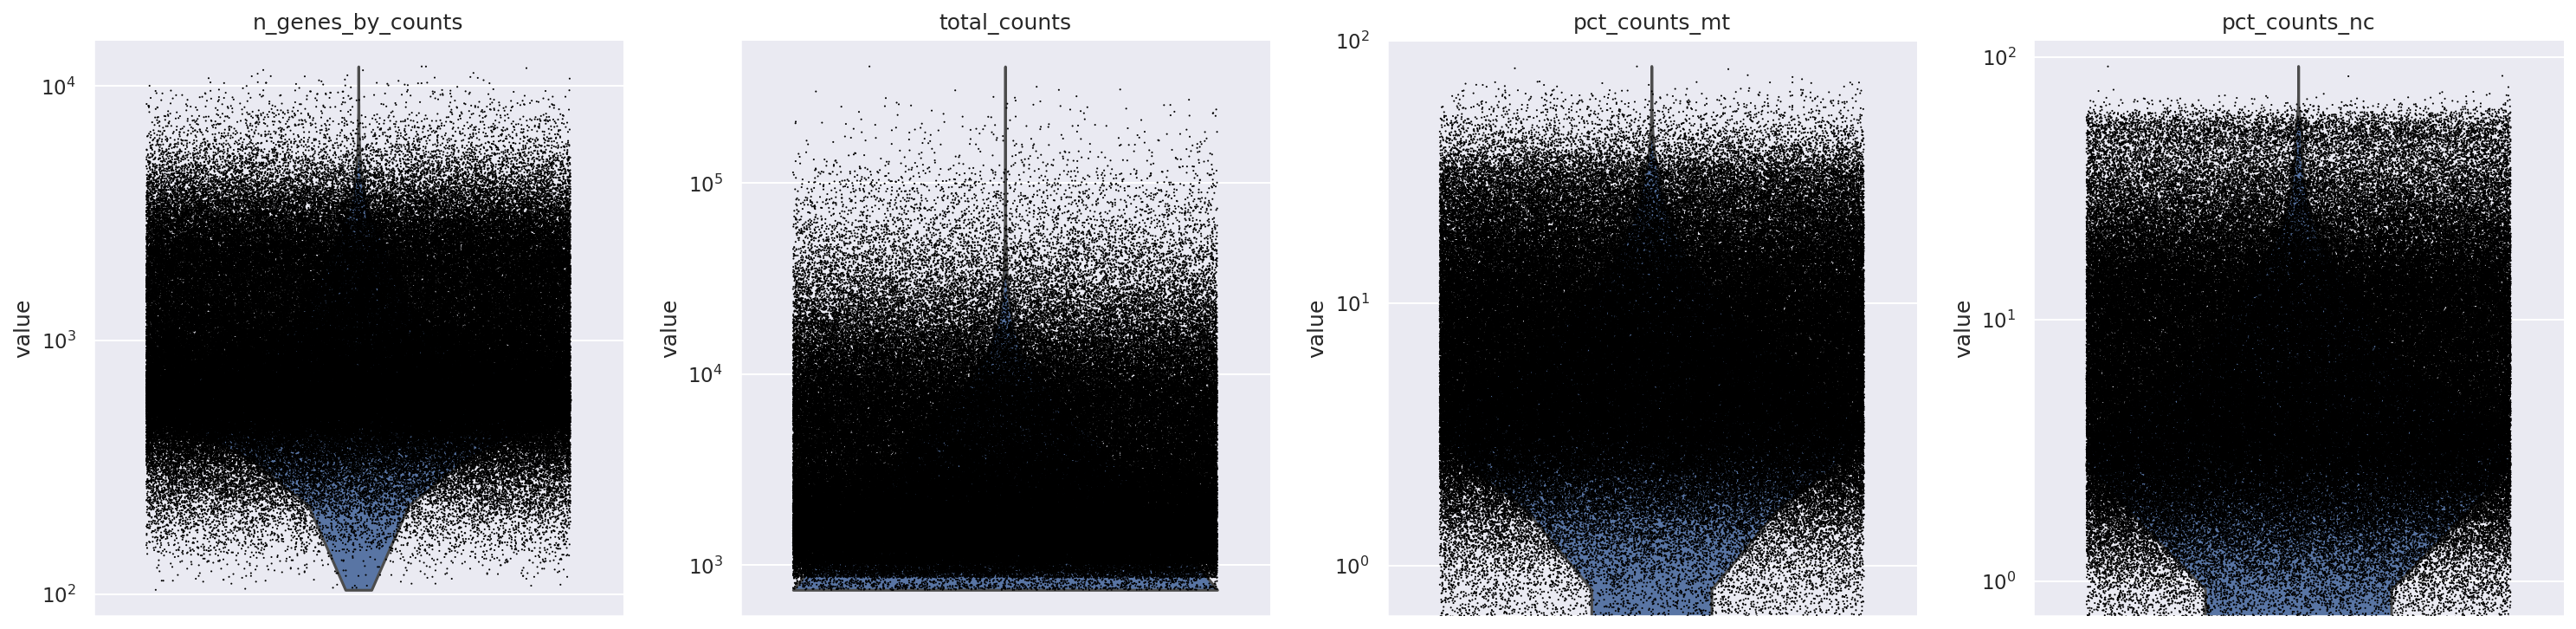

In [48]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_nc'],
             jitter=0.4, multi_panel=True, log =True)

### Plot all cells based on both parameters and choose a cut-off
Ideally we should do this based on the quantiles of the distribution

<Figure size 750x750 with 0 Axes>

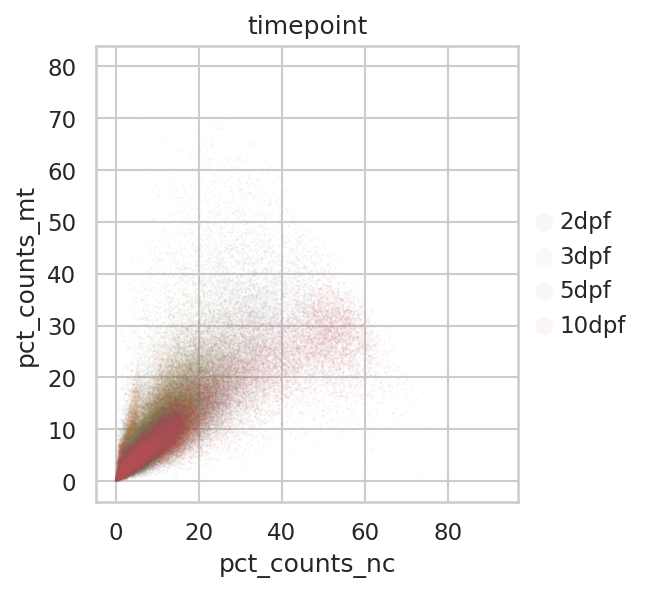

In [49]:
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")

sc.pl.scatter(adata, x='pct_counts_nc', y='pct_counts_mt',alpha = 0.05, 
             size = 4, color ='timepoint')

**Jun 21, 2022** <br>
Adult samples <br> 
10% mt content seems reasonable. <br>
1000 counts? <br>

Text(0.5, 1.0, 'NC content per time-point')

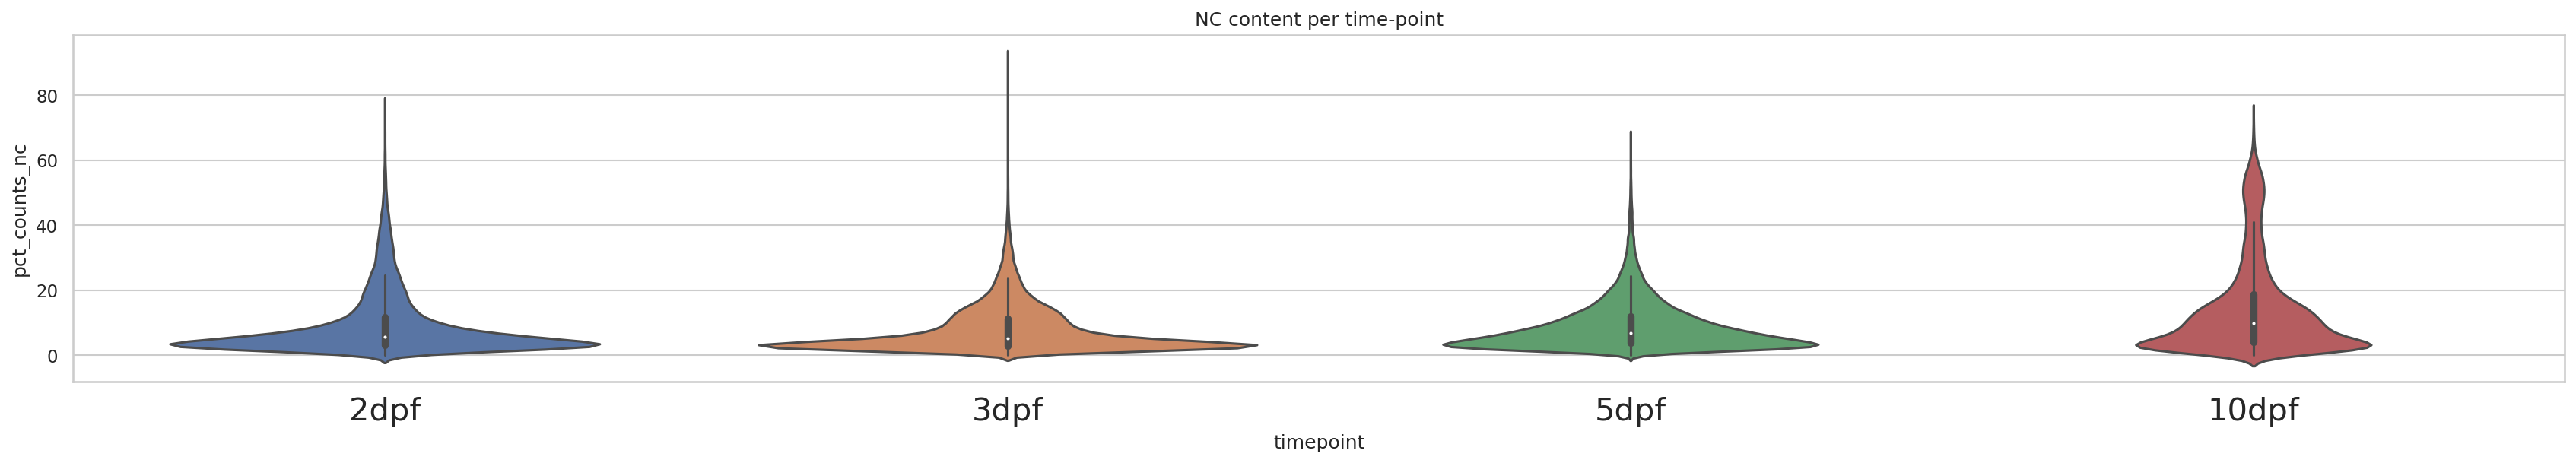

In [50]:
violin_width = 28 
violin_height = 4
plt.figure(figsize=(violin_width,violin_height))


res = sns.violinplot(data =adata.obs, x= 'timepoint',y='pct_counts_nc' )
res =res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20) # assign to variable to supress text

plt.title('NC content per time-point')

Text(0.5, 1.0, 'MT content per time-point')

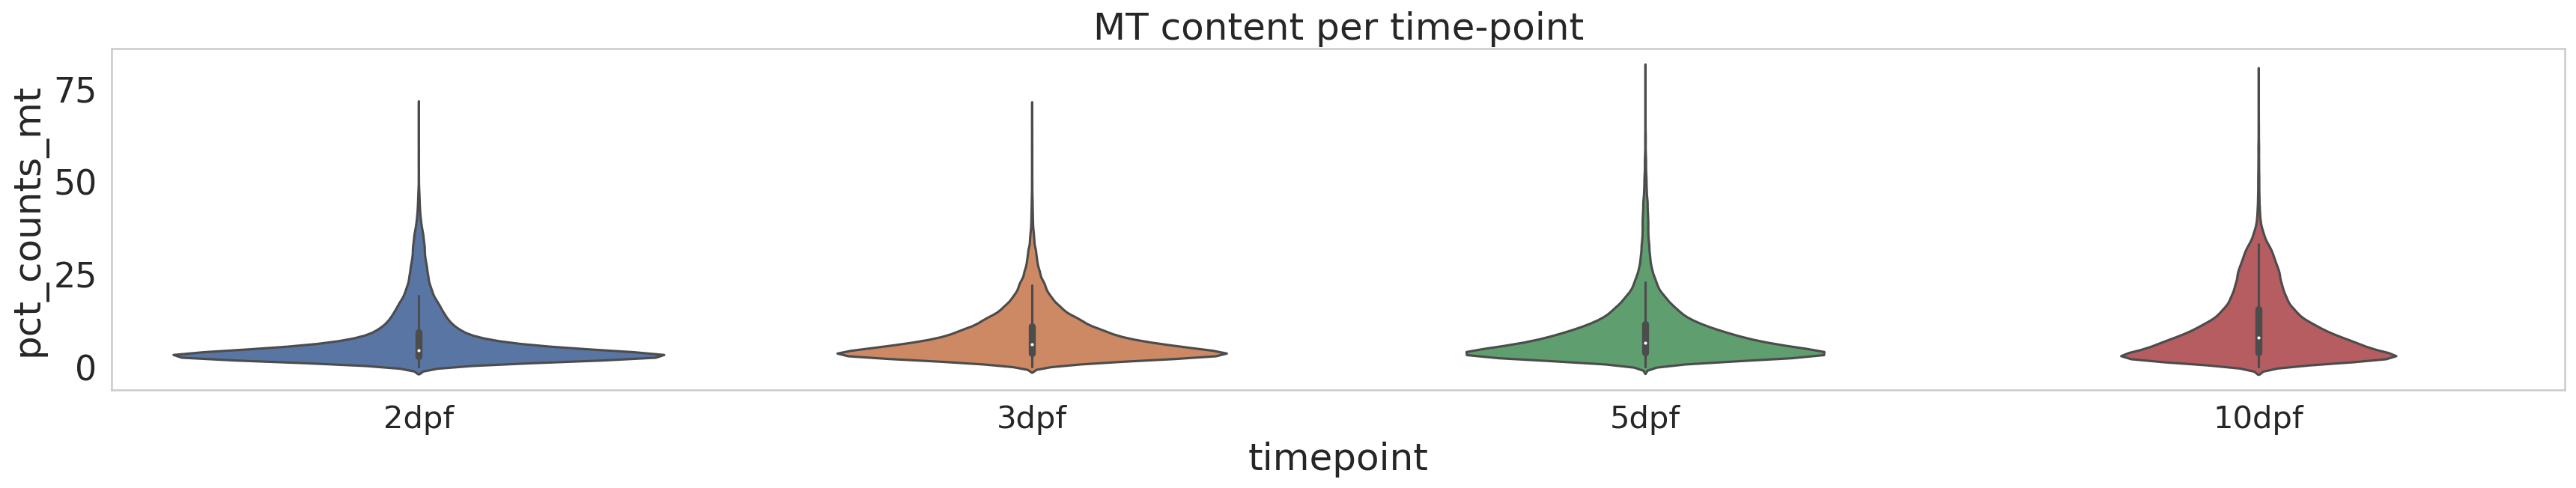

In [51]:
violin_width = 28 
violin_height = 4
plt.figure(figsize=(violin_width,violin_height))

sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})


res = sns.violinplot(data =adata.obs, x= 'timepoint',y='pct_counts_mt' )
res =res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20) # assign to variable to supress text

plt.title('MT content per time-point')

### Apply filteres based on library size, number of genes and NC content 
1st round of filters <br>
* Number of counts min 17k, max 100k
* % Mitochondrial < 4 
* % NC < 4

In [52]:
# Apply all filters 
adata = adata[adata.obs.pct_counts_nc < 15, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata = adata[adata.obs['total_counts'].between(2000,20000), :]

### Output: plot 3, distribution of counts after QC 

Trying to set attribute `.obs` of view, copying.


Text(0.5, 1.0, 'Total counts per cell across all samples')

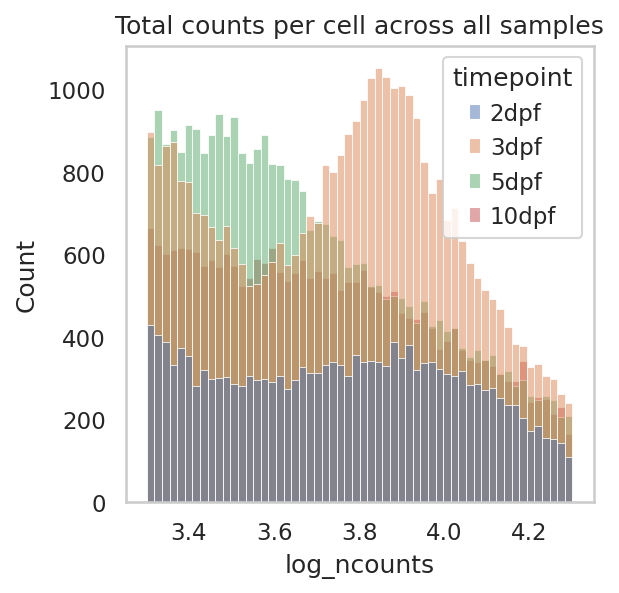

In [53]:
adata.obs['log_ncounts'] = np.log10(adata.obs['total_counts'])

sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})



sns.histplot(data = adata.obs, 
            x = 'log_ncounts', hue = 'timepoint')
plt.title('Total counts per cell across all samples')

In [54]:
adata.obs['fish'].value_counts() 

TDR69    12317
TDR70    12294
TDR51    10302
TDR74     9063
TDR73     8883
TDR67     8511
TDR52     8149
TDR53     7962
TDR54     6792
TDR47     6248
TDR71     5893
TDR48     5795
TDR68     4655
TDR50     3194
TDR72     2598
TDR49     1462
Name: fish, dtype: int64

### Output (optional), distribution of counts per sample


Text(0.5, 1.0, 'Distribution counts per cell')

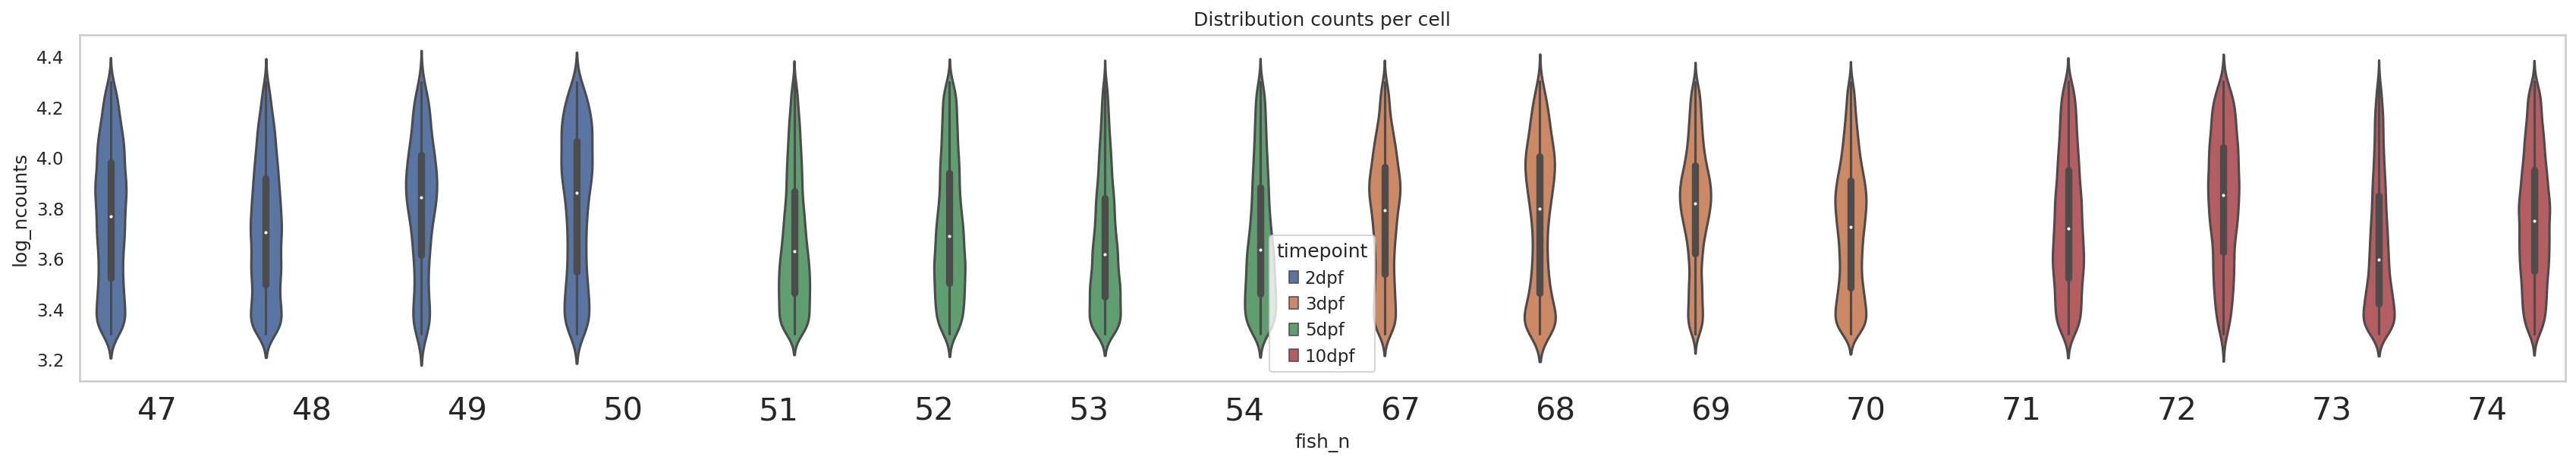

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

violin_width = 28 
violin_height = 4
plt.figure(figsize=(violin_width,violin_height))


res = sns.violinplot(data =adata.obs, x= 'fish_n',y='log_ncounts', hue='timepoint' )
res =res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 20) # assign to variable to supress text

plt.title('Distribution counts per cell')

### save the file as h5 and csv 

## Scanpy normalization steps
Here are the core QC and normalization steps from scanpy

In [56]:
adata.layers['counts'] = adata.X.copy() 


In [57]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata.copy() 

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pp.scale(adata, max_value=10)


filtered out 4165 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


PCA and clustering

In [58]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:24)


In [59]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, 
               metric='cosine', 
               n_neighbors=30, n_pcs=50 )

sc.tl.umap(adata, min_dist=0.3)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:44)


In [61]:
adata

AnnData object with n_obs × n_vars = 114118 × 27895
    obs: 'n_genes', 'n_counts', '10X_run', 'fish', 'fish_n', 'timepoint', 'log_ncounts', 'log_ngenes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'timepoint_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Dummy UMAP 

## Final object with UMAP 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

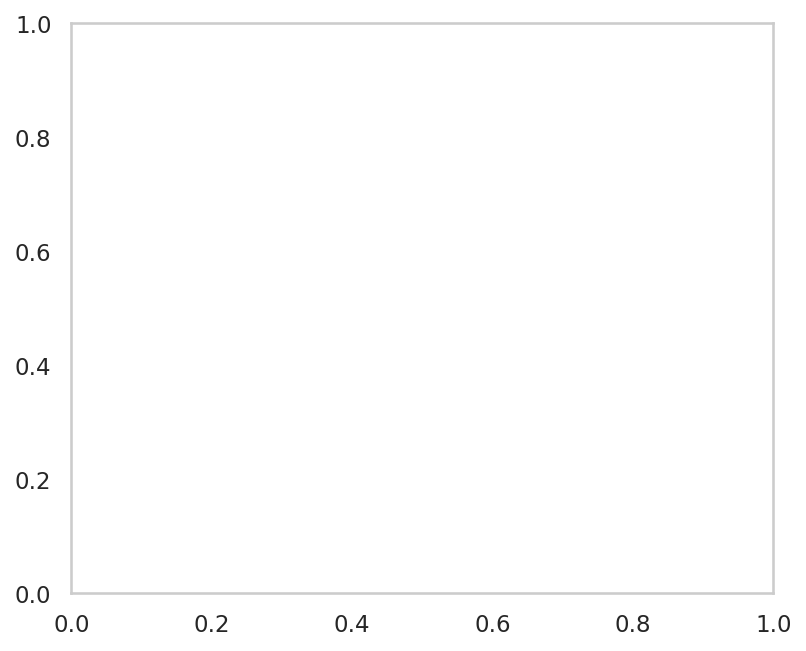

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

sc.pl.umap(adata, color='timepoint', add_outline=False, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='2-10 dpf', 
               ax=ax, show = False)

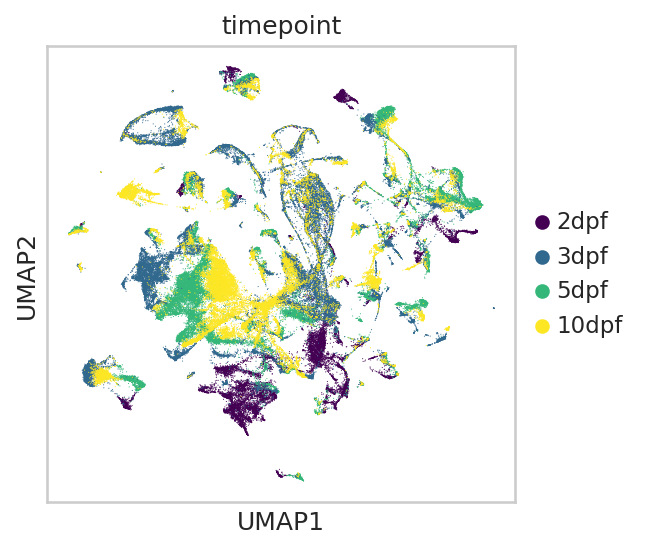

In [79]:
sc.pl.umap(adata, color = 'timepoint', palette = 'viridis')

<AxesSubplot:title={'center':'2-10 dpf'}, xlabel='UMAP1', ylabel='UMAP2'>

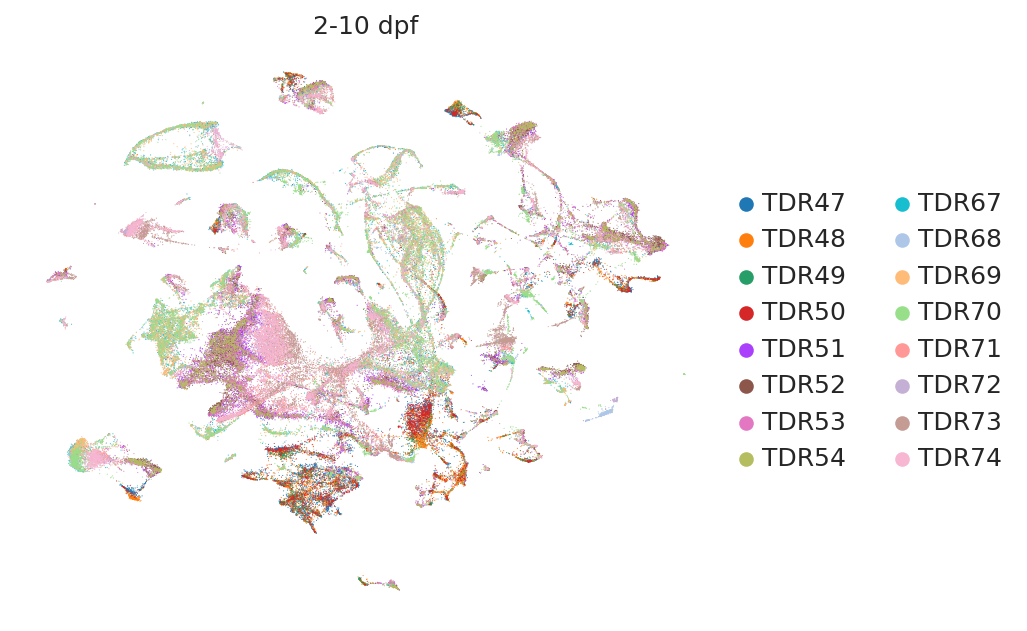

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))

sc.pl.umap(adata, color='fish', add_outline=False, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='2-10 dpf', 
               ax=ax, show = False)

In [301]:
fig.savefig('figures/adult_figures/UMAP_2dpf_10dpf_fish.png', dpi=400, bbox_inches='tight', transparent=True)


In [298]:
pwd

'/data/alejandro/danio-atlas/data'

In [ ]:
adata.obs.timepoint.value_counts()

# Output: 
h5ad file 

In [80]:
adata

AnnData object with n_obs × n_vars = 114118 × 27895
    obs: 'n_genes', 'n_counts', '10X_run', 'fish', 'fish_n', 'timepoint', 'log_ncounts', 'log_ngenes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_nc', 'pct_counts_nc'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'nc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'timepoint_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'fish_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [74]:
adata.obs['timepoint'].value_counts() 

3dpf     37777
5dpf     33205
10dpf    26437
2dpf     16699
Name: timepoint, dtype: int64

In [78]:
np.min(adata.obs['n_counts']) 

2000.0

In [81]:
#adata.write('/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/' + 'TDR18_TDR64_processed.h5ad')

adata.write('/mnt/ibm_lg/alejandro/danio-atlas/atlas_objects/' + 'TDR47_54_TDR67_74_processed_min2000counts.h5ad')

In [37]:
adata.obs.fish.value_counts()  

TDR51    5184
TDR52    4415
TDR53    3899
TDR47    3682
TDR54    3451
TDR48    3379
TDR50    1783
TDR61     806
TDR62     784
TDR59     692
TDR60     673
TDR63     605
TDR58     552
TDR64     399
Name: fish, dtype: int64